In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error indice
indice_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indice_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206*1e-3)

In [10]:
normalized_scan_100206_full = scan_100206_long_no_background / S0_100206

In [11]:
normalized_scan_100206_full.shape

(935442, 288)

In [12]:
rand_half_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 9))

In [13]:
rand_half_bval_indice_100206

array([ 16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287])

In [14]:
bvals_100206_half = bvals_all_100206[rand_half_bval_indice_100206]*1e-3

In [15]:
normalized_scan_100206_half = normalized_scan_100206_full[:, rand_half_bval_indice_100206]

In [16]:
big_b_indice_100206_half = np.where(bvals_100206_half != 0.005)[0]

In [17]:
big_b_indice_100206_half

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143])

In [18]:
bvals_100206_half_no_b5 = bvals_100206_half[big_b_indice_100206_half]

In [19]:
normalized_scan_100206_half_no_b5 = normalized_scan_100206_half[:, big_b_indice_100206_half]

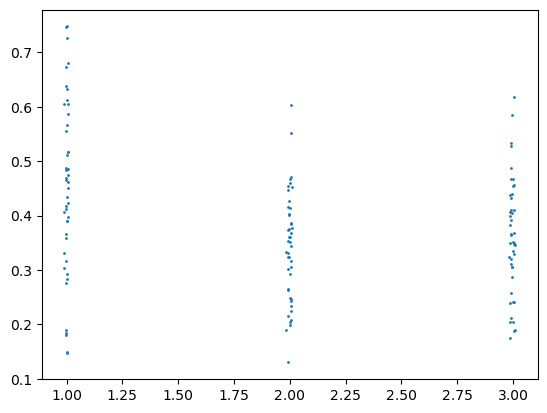

In [20]:
plt.plot(bvals_100206_half_no_b5, normalized_scan_100206_half_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [24]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_half = n_100206_all[:, rand_half_bval_indice_100206]

In [25]:
print(n_100206_half.shape)
print(big_b_indice_100206_half)

(3, 144)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143]


In [26]:
n_100206_half_no_b5 = n_100206_half[:,big_b_indice_100206_half].T
print(n_100206_half_no_b5.shape)

b_values_100206_half_no_b5 = torch.FloatTensor(bvals_100206_half_no_b5)
gradient_directions_100206_half_no_b5 = torch.FloatTensor(n_100206_half_no_b5)

net = BallStickNet(gradient_directions_100206_half_no_b5, b_values_100206_half_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(135, 3)


In [27]:
batch_size = 128
num_batches = len(normalized_scan_100206_half_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_half_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [28]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.58it/s]


Loss: 2589.789047509432
Average Loss: 0.35437726430068855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.57it/s]


Loss: 596.5003827442415
Average Loss: 0.08162293140999473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.57it/s]


Loss: 419.01447754958645
Average Loss: 0.05733640907903482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.90it/s]


Loss: 416.19600043818355
Average Loss: 0.056950738976215595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.88it/s]


Loss: 415.7573344116099
Average Loss: 0.05689071352101942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.16it/s]


Loss: 414.4362273346633
Average Loss: 0.05670993805893039
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.08it/s]


Loss: 414.5965251917951
Average Loss: 0.056731872631608525
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.78it/s]


Loss: 414.48969875182956
Average Loss: 0.05671725489214964
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.84it/s]


Loss: 413.9067386058159
Average Loss: 0.05663748475722714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.12it/s]


Loss: 413.90949535905384
Average Loss: 0.056637861981260786
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  2%|██▉                                                                                                                                                           | 137/7308 [00:02<00:49, 144.32it/s]

X_batch: 
torch.Size([128, 135])
tensor([[0.6504, 0.7855, 0.7356,  ..., 0.8344, 0.5510, 0.6327],
        [0.4513, 0.3144, 0.2917,  ..., 0.4271, 0.3229, 0.2514],
        [0.3401, 0.2465, 0.1882,  ..., 0.5436, 0.2463, 0.2400],
        ...,
        [0.5394, 0.3637, 0.4390,  ..., 0.3836, 0.2159, 0.3420],
        [0.6224, 0.4282, 0.1094,  ..., 0.4492, 0.3354, 0.2394],
        [0.1068, 0.1113, 0.0859,  ..., 0.1269, 0.0725, 0.0917]])
X_pred: 
torch.Size([128, 135])
tensor([[0.7269, 0.6607, 0.4991,  ..., 0.6978, 0.6641, 0.5634],
        [0.4741, 0.2861, 0.1769,  ..., 0.4630, 0.2871, 0.1929],
        [0.4724, 0.2866, 0.1783,  ..., 0.4612, 0.2877, 0.1951],
        ...,
        [0.4654, 0.3314, 0.2318,  ..., 0.4502, 0.3323, 0.2560],
        [0.5294, 0.3886, 0.2734,  ..., 0.5127, 0.3904, 0.3090],
        [0.1301, 0.0877, 0.0664,  ..., 0.1249, 0.0880, 0.0742]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.83it/s]


Loss: 414.08305782824755
Average Loss: 0.056661611634954506
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.60it/s]


Loss: 413.14160639001057
Average Loss: 0.05653278686234409
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.97it/s]


Loss: 413.2417853178922
Average Loss: 0.05654649498055449
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.82it/s]


Loss: 412.9809143652674
Average Loss: 0.05651079835321119
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.35it/s]


Loss: 413.03314432129264
Average Loss: 0.05651794530942702
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.09it/s]


Loss: 412.3547251243144
Average Loss: 0.05642511290699431
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.69it/s]


Loss: 412.8435249070171
Average Loss: 0.05649199848207678
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.94it/s]


Loss: 412.7286407784559
Average Loss: 0.05647627815797152
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.99it/s]


Loss: 412.1200497155078
Average Loss: 0.056393000782089184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.57it/s]


Loss: 412.1708113984205
Average Loss: 0.05639994682518069
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.57it/s]


Loss: 412.46106743160635
Average Loss: 0.05643966439950826
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.05it/s]


Loss: 411.7307831388898
Average Loss: 0.056339734967007365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.37it/s]


Loss: 411.97692965809256
Average Loss: 0.05637341675671765
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.12it/s]


Loss: 412.10566598689184
Average Loss: 0.056391032565256134
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.96it/s]


Loss: 411.88986158836633
Average Loss: 0.05636150268040043
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.74it/s]


Loss: 411.72328729671426
Average Loss: 0.05633870926337086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.56it/s]


Loss: 411.5268165562302
Average Loss: 0.05631182492559253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.61it/s]


Loss: 411.5428657140583
Average Loss: 0.05631402103366972
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.95it/s]


Loss: 411.1118590780534
Average Loss: 0.05625504366147419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.89it/s]


Loss: 411.1156170400791
Average Loss: 0.056255557887257675
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.16it/s]


Loss: 411.25437957420945
Average Loss: 0.05627454564507518
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.07it/s]


Loss: 410.72951163863763
Average Loss: 0.056202724635828906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.40it/s]


Loss: 410.4734483566135
Average Loss: 0.05616768587255248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.82it/s]


Loss: 409.83650846220553
Average Loss: 0.056080529346224074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.34it/s]


Loss: 409.94197045150213
Average Loss: 0.05609496037924222
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.39it/s]


Loss: 409.3842269307934
Average Loss: 0.05601864079512772
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.74it/s]


Loss: 408.517997891875
Average Loss: 0.055900109180606866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.53it/s]


Loss: 408.3785545732826
Average Loss: 0.055881028266732705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.18it/s]


Loss: 407.62533175968565
Average Loss: 0.05577796001090389
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.79it/s]


Loss: 407.023650490446
Average Loss: 0.05569562814592857
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.61it/s]


Loss: 407.1653660342563
Average Loss: 0.05571501998279369
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.73it/s]


Loss: 406.4302141980734
Average Loss: 0.055614424493441894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.97it/s]


Loss: 405.7160406301264
Average Loss: 0.05551669959361335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.80it/s]


Loss: 405.662982347887
Average Loss: 0.05550943929226697
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.39it/s]


Loss: 405.1742036193609
Average Loss: 0.055442556598161045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.85it/s]


Loss: 405.26063112262636
Average Loss: 0.05545438302170585
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.99it/s]


Loss: 404.64257007464767
Average Loss: 0.05536980980769673
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.55it/s]


Loss: 404.43236994720064
Average Loss: 0.055341046790804684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.86it/s]


Loss: 403.96309980074875
Average Loss: 0.05527683357974121
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.36it/s]


Loss: 403.943963104859
Average Loss: 0.05527421498424453
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.82it/s]


Loss: 403.4391373747494
Average Loss: 0.05520513647711404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.93it/s]


Loss: 403.43464971217327
Average Loss: 0.055204522401775216
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.87it/s]


Loss: 402.96204164996743
Average Loss: 0.05513985244252428
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.56it/s]


Loss: 402.69813405140303
Average Loss: 0.0551037402916534
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.78it/s]


Loss: 402.5974884086754
Average Loss: 0.0550899683098899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.83it/s]


Loss: 402.20376604422927
Average Loss: 0.05503609278109322
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.50it/s]


Loss: 401.9006941325497
Average Loss: 0.05499462152881085
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.68it/s]


Loss: 401.8863033740781
Average Loss: 0.05499265235003806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.02it/s]


Loss: 401.3938115830533
Average Loss: 0.05492526157403576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.53it/s]


Loss: 401.2513735841494
Average Loss: 0.05490577087905712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.19it/s]


Loss: 401.2187755717896
Average Loss: 0.05490131028623284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.91it/s]


Loss: 400.98209659475833
Average Loss: 0.05486892400037744
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.49it/s]


Loss: 400.70484756468795
Average Loss: 0.054830986256799115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.82it/s]


Loss: 400.6782453684136
Average Loss: 0.05482734610952567
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.25it/s]


Loss: 400.3509545372799
Average Loss: 0.05478256082885603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.54it/s]


Loss: 400.16256572911516
Average Loss: 0.054756782393146575
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.00it/s]


Loss: 400.1043339916505
Average Loss: 0.054748814175102696
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.22it/s]


Loss: 399.98953083064407
Average Loss: 0.0547331049303016
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.65it/s]


Loss: 399.79981572763063
Average Loss: 0.054707145009254325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.35it/s]


Loss: 399.7387120772619
Average Loss: 0.05469878380914914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.11it/s]


Loss: 399.4909844675567
Average Loss: 0.05466488566879539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.84it/s]


Loss: 399.5455419078935
Average Loss: 0.0546723511094545
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.07it/s]


Loss: 399.47103810030967
Average Loss: 0.05466215628083055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.68it/s]


Loss: 399.3104161845986
Average Loss: 0.054640177365161274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.11it/s]


Loss: 399.2406293100212
Average Loss: 0.05463062798440355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.91it/s]


Loss: 399.30327518074773
Average Loss: 0.05463920021630374
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.86it/s]


Loss: 399.1564056233037
Average Loss: 0.054619103123057434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.07it/s]


Loss: 398.95135695138015
Average Loss: 0.05459104501250413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.33it/s]


Loss: 399.0729793587234
Average Loss: 0.05460768737804097
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.27it/s]


Loss: 398.78882097033784
Average Loss: 0.05456880418313326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.72it/s]


Loss: 398.7157129771076
Average Loss: 0.05455880035264198
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.89it/s]


Loss: 398.7933422443457
Average Loss: 0.054569422857737505
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.13it/s]


Loss: 398.53003407549113
Average Loss: 0.05453339273063644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.32it/s]


Loss: 398.57251438708045
Average Loss: 0.05453920558115496
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.90it/s]


Loss: 398.42049378855154
Average Loss: 0.05451840363828018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.26it/s]


Loss: 398.53358471998945
Average Loss: 0.05453387858784749
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.24it/s]


Loss: 398.3633344557602
Average Loss: 0.0545105821641708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.48it/s]


Loss: 398.41303428821266
Average Loss: 0.05451738290752773
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.78it/s]


Loss: 398.1618442661129
Average Loss: 0.054483010983321416
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.36it/s]


Loss: 398.0380552469287
Average Loss: 0.05446607214654197
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.12it/s]


Loss: 398.0437094664667
Average Loss: 0.05446684584927021
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.19it/s]


Loss: 398.2658023261465
Average Loss: 0.05449723622415798
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.79it/s]


Loss: 398.0786246259231
Average Loss: 0.054471623512031074
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.15it/s]


Loss: 397.9691793057136
Average Loss: 0.054456647414574934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.92it/s]


Loss: 397.8711823876947
Average Loss: 0.054443237874616135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.49it/s]


Loss: 397.99243500479497
Average Loss: 0.05445982963940818
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.03it/s]


Loss: 397.8372737963218
Average Loss: 0.054438597946951536
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.76it/s]


Loss: 397.68308877851814
Average Loss: 0.05441749983285689
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.51it/s]


Loss: 397.71505197742954
Average Loss: 0.05442187356012993
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.98it/s]


Loss: 397.76393121061847
Average Loss: 0.054428562015683975
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.11it/s]


Loss: 397.7651179640088
Average Loss: 0.05442872440667882
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.76it/s]


Loss: 397.66214883862995
Average Loss: 0.0544146344880446
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.85it/s]


Loss: 397.5947484364733
Average Loss: 0.05440541166344736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.22it/s]


Loss: 397.6251291532535
Average Loss: 0.05440956884965155
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.07it/s]


Loss: 397.5501486349385
Average Loss: 0.054399308789674125
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.09it/s]


Loss: 397.3618159336038
Average Loss: 0.054373538031418145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.69it/s]


Loss: 397.5279765697196
Average Loss: 0.054396274845336566
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.57it/s]


Loss: 397.5681012594141
Average Loss: 0.054401765361167774
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.09it/s]


Loss: 397.46185508649796
Average Loss: 0.05438722702333032
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.06it/s]


Loss: 397.4278816492297
Average Loss: 0.05438257822239049
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.96it/s]


Loss: 397.3227336406708
Average Loss: 0.05436819015334849
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.59it/s]


Loss: 397.2443374681752
Average Loss: 0.05435746270774155
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.08it/s]


Loss: 397.2994796503335
Average Loss: 0.05436500816233354
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.65it/s]


Loss: 397.2899798268918
Average Loss: 0.054363708241227666
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.83it/s]


Loss: 397.23442922974937
Average Loss: 0.054356106900622515
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.78it/s]


Loss: 397.26264651329257
Average Loss: 0.05435996805053264
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.87it/s]


Loss: 397.1470671975985
Average Loss: 0.05434415259956192
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.00it/s]


Loss: 397.3238976774737
Average Loss: 0.05436834943588858
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.25it/s]


Loss: 397.0489294996951
Average Loss: 0.05433072379579845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.82it/s]


Loss: 397.1082873507403
Average Loss: 0.05433884610710732
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.24it/s]


Loss: 397.16677586291917
Average Loss: 0.05434684946126425
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.52it/s]


Loss: 397.02756014699116
Average Loss: 0.05432779969170651
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.55it/s]


Loss: 397.1929247775115
Average Loss: 0.054350427583129655
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.63it/s]


Loss: 396.96692238608375
Average Loss: 0.05431950224221179
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.56it/s]


Loss: 397.02325710700825
Average Loss: 0.05432721087944831
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.73it/s]


Loss: 396.9777398756705
Average Loss: 0.05432098246793521
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.32it/s]


Loss: 397.0210870525334
Average Loss: 0.05432691393712827
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.75it/s]


Loss: 396.97068210458383
Average Loss: 0.054320016708344805
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.29it/s]


Loss: 396.8526011609938
Average Loss: 0.054303858943759414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.34it/s]


Loss: 396.9540674693417
Average Loss: 0.05431774322240581
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.76it/s]


Loss: 396.82679506461136
Average Loss: 0.054300327731884424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.19it/s]


Loss: 396.76742062717676
Average Loss: 0.054292203150954677
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.37it/s]


Loss: 396.866979498649
Average Loss: 0.05430582642291311
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.96it/s]


Loss: 396.75191937270574
Average Loss: 0.05429008201596959
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.25it/s]


Loss: 396.78430377552286
Average Loss: 0.054294513379245055
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.21it/s]


Loss: 396.80968785937876
Average Loss: 0.054297986844468904
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.87it/s]


Loss: 396.7397867324762
Average Loss: 0.05428842182984075
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.25it/s]


Loss: 396.604612454772
Average Loss: 0.054269925075912974
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.46it/s]


Loss: 396.7028789166361
Average Loss: 0.05428337149926603
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.35it/s]


Loss: 396.6620432594791
Average Loss: 0.05427778369724673
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.44it/s]


Loss: 396.6491215140559
Average Loss: 0.054276015532848366
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.50it/s]


Loss: 396.67733255401254
Average Loss: 0.054279875828408944
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.35it/s]


Loss: 396.6837173930835
Average Loss: 0.05428074950644273
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.61it/s]


Loss: 396.5590799425263
Average Loss: 0.054263694573416295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.39it/s]


Loss: 396.54147005756386
Average Loss: 0.05426128490114448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.55it/s]


Loss: 396.488244375214
Average Loss: 0.05425400169337903
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.89it/s]


Loss: 396.62041241745465
Average Loss: 0.054272087085037585
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.47it/s]


Loss: 396.54133456922136
Average Loss: 0.054261266361415074
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.22it/s]


Loss: 396.622604762204
Average Loss: 0.05427238707747729
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.63it/s]


Loss: 396.5151605140418
Average Loss: 0.054257684799403634
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.79it/s]


Loss: 396.62651328509673
Average Loss: 0.05427292190545932
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.34it/s]


Loss: 396.5167662445456
Average Loss: 0.054257904521694794
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.15it/s]


Loss: 396.38339179591276
Average Loss: 0.05423965404979649
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.34it/s]


Loss: 396.5005732248537
Average Loss: 0.05425568872808617
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.96it/s]


Loss: 396.4170754456427
Average Loss: 0.05424426319726912
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.70it/s]


Loss: 396.5240973359905
Average Loss: 0.054258907681443695
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.39it/s]


Loss: 396.413183161756
Average Loss: 0.054243730591373295
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.68it/s]


Loss: 396.34357907110825
Average Loss: 0.0542342062221002
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.71it/s]


Loss: 396.2951519167982
Average Loss: 0.054227579627367024
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.45it/s]


Loss: 396.44749991060235
Average Loss: 0.05424842636981422
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.42it/s]


Loss: 396.29991636192426
Average Loss: 0.05422823157661799
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.06it/s]


Loss: 396.2758007263765
Average Loss: 0.05422493168122283
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.45it/s]


Loss: 396.3096756990999
Average Loss: 0.054229567008634356
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.09it/s]


Loss: 396.38161362265237
Average Loss: 0.05423941073106901
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.15it/s]


Loss: 396.3332074501086
Average Loss: 0.054232787007404026
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.92it/s]


Loss: 396.29818879649974
Average Loss: 0.05422799518288174
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.92it/s]


Loss: 396.24325639242306
Average Loss: 0.05422047843355543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.61it/s]


Loss: 396.28826315002516
Average Loss: 0.05422663699370897
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.84it/s]


Loss: 396.4022313868627
Average Loss: 0.054242231990539506
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.88it/s]


Loss: 396.27851917548105
Average Loss: 0.05422530366385893
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.33it/s]


Loss: 396.1753460788168
Average Loss: 0.05421118583453979
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.21it/s]


Loss: 396.1810497913975
Average Loss: 0.05421196630971504
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.59it/s]


Loss: 396.1779330712743
Average Loss: 0.05421153982912894
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.62it/s]


Loss: 396.20212389039807
Average Loss: 0.05421485001236974
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.67it/s]


Loss: 396.20449159969576
Average Loss: 0.05421517400105306
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.56it/s]


Loss: 395.6742874025367
Average Loss: 0.054142622797281985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.35it/s]


Loss: 396.1412264574319
Average Loss: 0.05420651703029993
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.22it/s]


Loss: 396.1602594652213
Average Loss: 0.05420912143749607
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.84it/s]


Loss: 396.09751497302204
Average Loss: 0.05420053571059415
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.94it/s]


Loss: 396.13745992816985
Average Loss: 0.05420600163220715
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.02it/s]


Loss: 396.1114162874874
Average Loss: 0.05420243791563867
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.94it/s]


Loss: 396.1843532298226
Average Loss: 0.05421241834015087
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.16it/s]


Loss: 396.0240890593268
Average Loss: 0.05419048837702885
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.73it/s]


Loss: 396.04011358576827
Average Loss: 0.054192681114637146
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.51it/s]


Loss: 396.0443492436316
Average Loss: 0.05419326070657247
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.82it/s]

Loss: 396.08114700671285
Average Loss: 0.05419829597793006
Done, best loss: 395.6742874025367
Done


<All keys matched successfully>

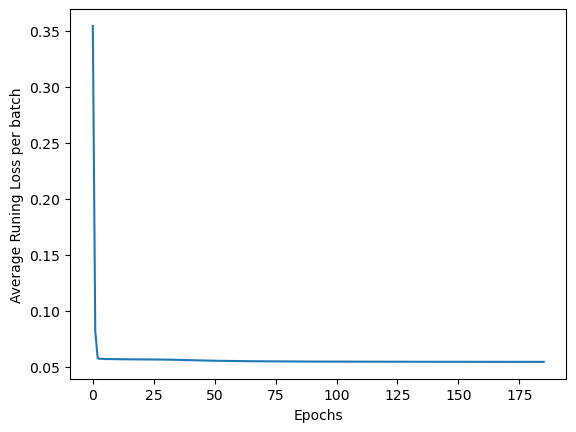

In [29]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [30]:
torch.save(final_model, 'model_100206_half_04.pt')